In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score, 
    f1_score, ConfusionMatrixDisplay
)
from sklearn.model_selection import StratifiedKFold, cross_val_score
import time
import warnings

warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Załadowano biblioteki.")

# --- FUNKCJE POMOCNICZE ---
def fix_data(df):
    feature_cols = [col for col in df.columns if col not in ['genre', 'filename']]
    for col in feature_cols:
        if df[col].dtype == 'object':
            df[col] = df[col].astype(str).str.replace(r'[\[\]]', '', regex=True)
            df[col] = pd.to_numeric(df[col], errors='coerce')
        if df[col].isna().sum() > 0:
            df[col] = df[col].fillna(df[col].mean())
    return df

# --- WCZYTANIE DANYCH ---
try:
    # Zakładamy ścieżki jak w poprzednich notatnikach
    train_df = fix_data(pd.read_csv('../data/processed/train_features.csv'))
    # Dla celów strojenia parametrów użyjemy zbioru walidacyjnego (jeśli istnieje) lub wydzielimy go
    # Tutaj dla uproszczenia (jak w Twoim kodzie) użyjemy Train/Test, ale
    # w idealnym świecie robimy Cross-Validation na Train.
    test_df = fix_data(pd.read_csv('../data/processed/test_features.csv'))

    X_train = train_df.drop(['genre', 'filename'], axis=1)
    y_train = train_df['genre']
    X_test = test_df.drop(['genre', 'filename'], axis=1)
    y_test = test_df['genre']

    # Standaryzacja (KRYTYCZNA dla SVM)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    print(f"Dane gotowe. Train: {X_train_scaled.shape}, Test: {X_test_scaled.shape}")

except FileNotFoundError:
    print("BŁĄD: Nie znaleziono plików. Sprawdź ścieżki!")

Załadowano biblioteki.
Dane gotowe. Train: (600, 44), Test: (200, 44)


Rozpoczynam testowanie kerneli...
Kernel: linear -> Acc: 0.6250 (Czas: 0.03s)
Kernel: poly -> Acc: 0.5700 (Czas: 0.01s)
Kernel: rbf -> Acc: 0.7050 (Czas: 0.02s)
Kernel: sigmoid -> Acc: 0.5350 (Czas: 0.02s)


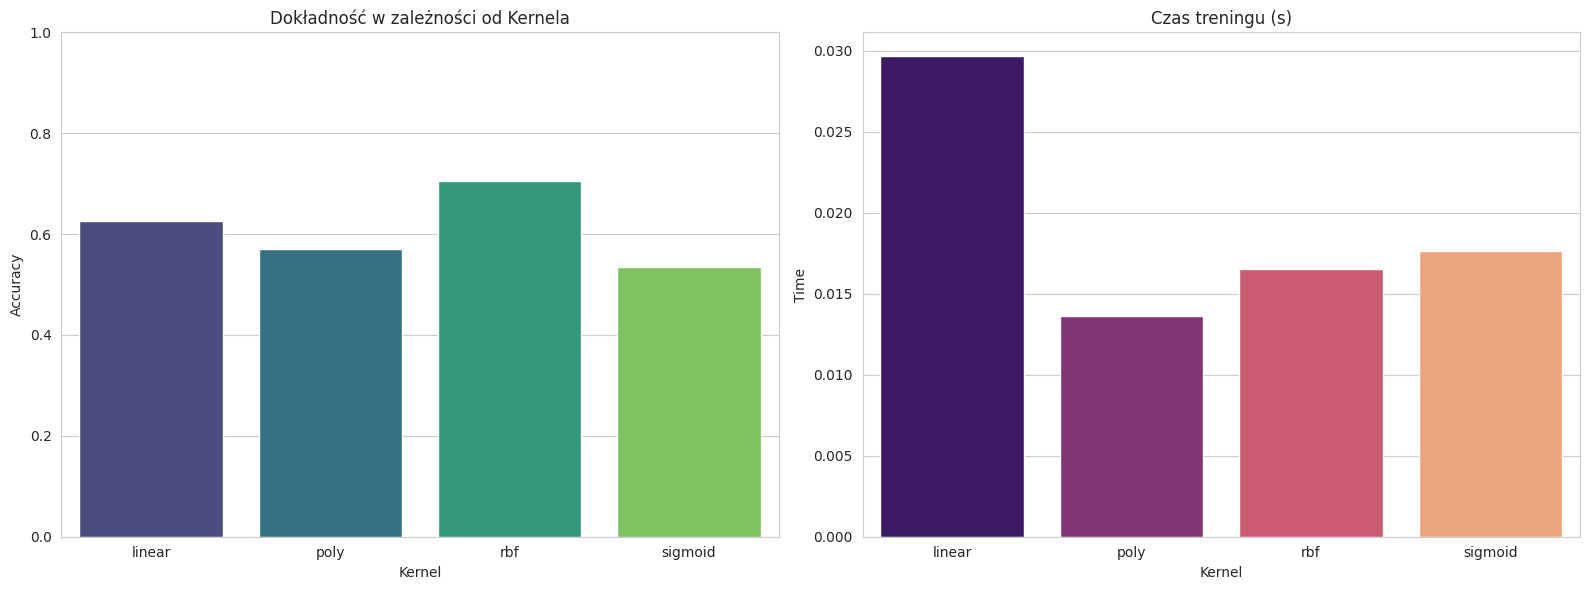

Zwycięski kernel: rbf


In [2]:
### EKSPERYMENT A: PORÓWNANIE KERNELI ###

kernels = ['linear', 'poly', 'rbf', 'sigmoid']
results_kernel = []

print("Rozpoczynam testowanie kerneli...")

for kern in kernels:
    start = time.time()
    # Używamy C=1.0 jako bazowego
    model = SVC(kernel=kern, C=1.0, random_state=42)
    model.fit(X_train_scaled, y_train)
    acc = model.score(X_test_scaled, y_test)
    elapsed = time.time() - start
    
    results_kernel.append({'Kernel': kern, 'Accuracy': acc, 'Time': elapsed})
    print(f"Kernel: {kern} -> Acc: {acc:.4f} (Czas: {elapsed:.2f}s)")

# Wizualizacja
df_kernel = pd.DataFrame(results_kernel)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Wykres dokładności
sns.barplot(data=df_kernel, x='Kernel', y='Accuracy', palette='viridis', ax=ax1)
ax1.set_title("Dokładność w zależności od Kernela")
ax1.set_ylim(0, 1.0)

# Wykres czasu (bo SVM potrafi być wolny!)
sns.barplot(data=df_kernel, x='Kernel', y='Time', palette='magma', ax=ax2)
ax2.set_title("Czas treningu (s)")

plt.tight_layout()
plt.show()

best_kernel = df_kernel.loc[df_kernel['Accuracy'].idxmax()]['Kernel']
print(f"Zwycięski kernel: {best_kernel}")

Rozpoczynam Grid Search dla kernela 'rbf'...
[25/25] Testowanie C=1000, gamma=0.0001...
Gotowe!


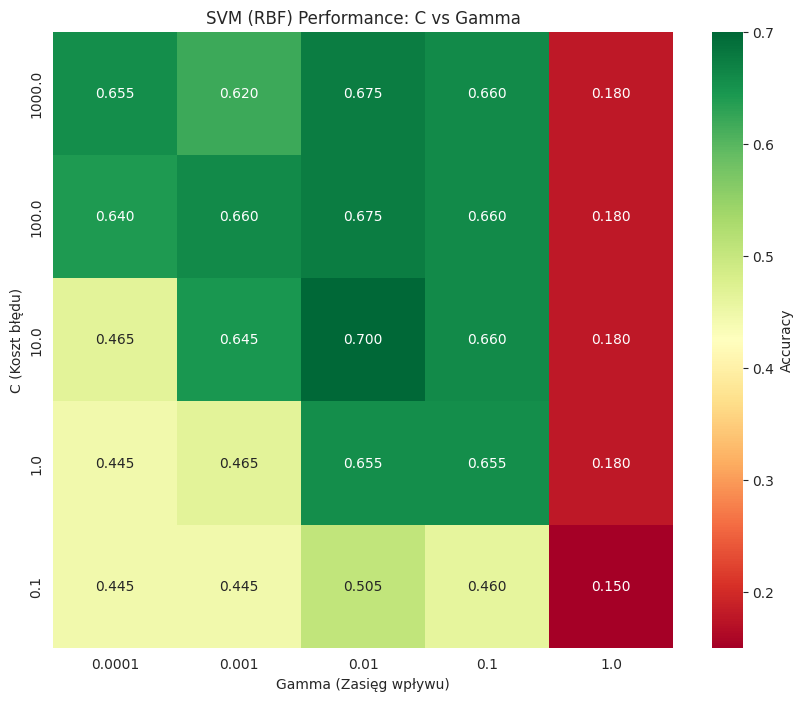

Najlepsze parametry: C=10.0, Gamma=0.01


In [4]:
### EKSPERYMENT B: STROJENIE C ORAZ GAMMA (HEATMAP) ###

# Definiujemy siatkę parametrów (skala logarytmiczna)
C_values = [0.1, 1, 10, 100, 1000] # Od "miękkiego" do "sztywnego" marginesu
gamma_values = [1, 0.1, 0.01, 0.001, 0.0001] # Od "wąskiego" do "szerokiego" zasięgu

results_grid = []

print(f"Rozpoczynam Grid Search dla kernela '{best_kernel}'...")
total_iter = len(C_values) * len(gamma_values)
curr = 0

for C in C_values:
    for gamma in gamma_values:
        curr += 1
        print(f"\r[{curr}/{total_iter}] Testowanie C={C}, gamma={gamma}...", end="", flush=True)
        
        # Trenujemy model
        model = SVC(kernel='rbf', C=C, gamma=gamma, random_state=42)
        model.fit(X_train_scaled, y_train)
        acc = model.score(X_test_scaled, y_test) # Oceniamy na teście (lub walidacji)
        
        results_grid.append({
            'C': C,
            'Gamma': gamma,
            'Accuracy': acc
        })

print("\nGotowe!")

# Przygotowanie danych do Heatmapy
df_grid = pd.DataFrame(results_grid)
pivot_table = df_grid.pivot(index='C', columns='Gamma', values='Accuracy')

# Wizualizacja
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, annot=True, fmt=".3f", cmap='RdYlGn', 
            cbar_kws={'label': 'Accuracy'})
plt.title(f"SVM (RBF) Performance: C vs Gamma")
plt.xlabel("Gamma (Zasięg wpływu)")
plt.ylabel("C (Koszt błędu)")
# Odwracamy oś Y, żeby małe C było na dole (intuicyjnie)
plt.gca().invert_yaxis()
plt.show()

# Pobranie najlepszych parametrów
best_row = df_grid.loc[df_grid['Accuracy'].idxmax()]
BEST_C = best_row['C']
BEST_GAMMA = best_row['Gamma']
print(f"Najlepsze parametry: C={BEST_C}, Gamma={BEST_GAMMA}")

Generowanie krzywej złożoności dla parametru C...


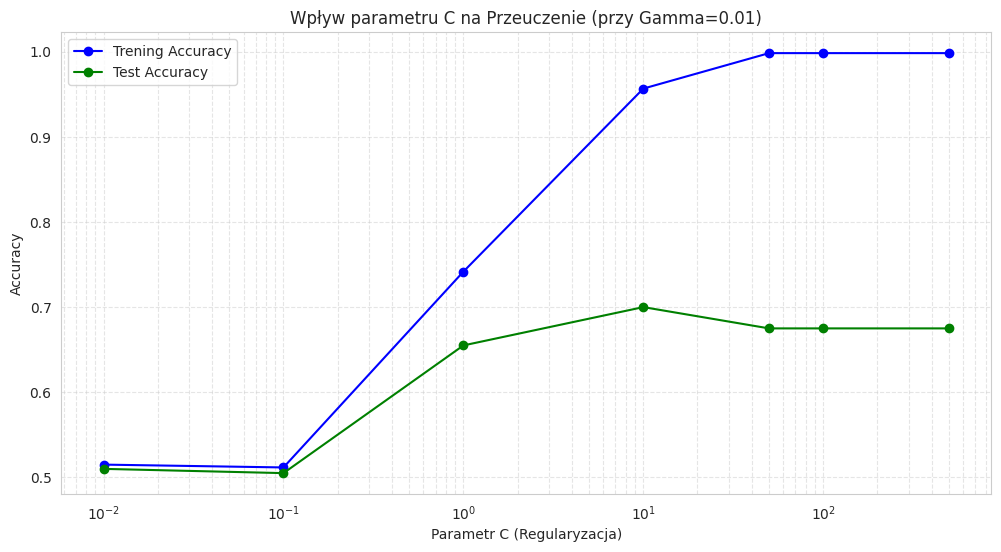

Interpretacja:
- Duża przepaść między linią niebieską a zieloną = Overfitting (za duże C).
- Obie linie nisko = Underfitting (za małe C).


In [5]:
### EKSPERYMENT C: KRZYWA ZŁOŻONOŚCI (C-parameter) ###

train_scores = []
test_scores = []
C_range = [0.01, 0.1, 1, 10, 50, 100, 500]

print("Generowanie krzywej złożoności dla parametru C...")

for C in C_range:
    model = SVC(kernel='rbf', C=C, gamma=BEST_GAMMA, random_state=42)
    model.fit(X_train_scaled, y_train)
    
    # Zapisujemy wyniki
    train_scores.append(model.score(X_train_scaled, y_train))
    test_scores.append(model.score(X_test_scaled, y_test))

# Wizualizacja
plt.figure(figsize=(12, 6))
plt.plot(C_range, train_scores, 'o-', color='blue', label='Trening Accuracy')
plt.plot(C_range, test_scores, 'o-', color='green', label='Test Accuracy')

plt.xscale('log') # Skala logarytmiczna dla C
plt.xlabel('Parametr C (Regularyzacja)')
plt.ylabel('Accuracy')
plt.title(f'Wpływ parametru C na Przeuczenie (przy Gamma={BEST_GAMMA})')
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.show()

print("Interpretacja:")
print("- Duża przepaść między linią niebieską a zieloną = Overfitting (za duże C).")
print("- Obie linie nisko = Underfitting (za małe C).")

Trenowanie finalnego modelu: Kernel=rbf, C=10.0, Gamma=0.01


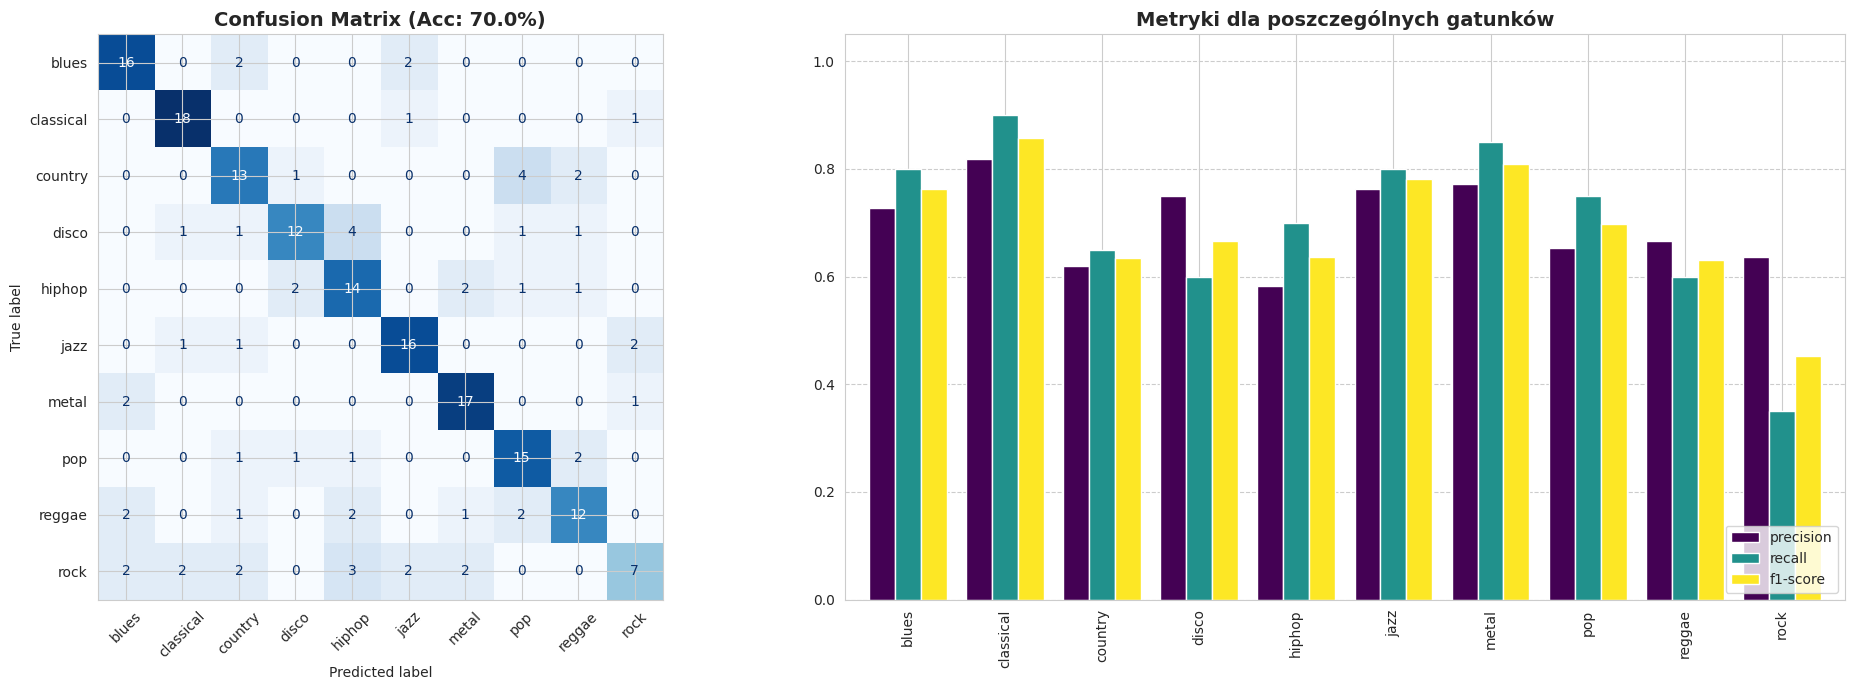


RAPORT TEKSTOWY:
              precision    recall  f1-score   support

       blues       0.73      0.80      0.76        20
   classical       0.82      0.90      0.86        20
     country       0.62      0.65      0.63        20
       disco       0.75      0.60      0.67        20
      hiphop       0.58      0.70      0.64        20
        jazz       0.76      0.80      0.78        20
       metal       0.77      0.85      0.81        20
         pop       0.65      0.75      0.70        20
      reggae       0.67      0.60      0.63        20
        rock       0.64      0.35      0.45        20

    accuracy                           0.70       200
   macro avg       0.70      0.70      0.69       200
weighted avg       0.70      0.70      0.69       200



In [6]:
### FINALNY MODEL SVM ###

print(f"Trenowanie finalnego modelu: Kernel=rbf, C={BEST_C}, Gamma={BEST_GAMMA}")
final_svm = SVC(kernel='rbf', C=BEST_C, gamma=BEST_GAMMA, random_state=42)
final_svm.fit(X_train_scaled, y_train)

# Predykcje
y_pred = final_svm.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

# --- WIZUALIZACJA ---
fig, axes = plt.subplots(1, 2, figsize=(20, 7))

# 1. Macierz Pomyłek
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=final_svm.classes_).plot(
    cmap='Blues', ax=axes[0], xticks_rotation=45, colorbar=False)
axes[0].set_title(f"Confusion Matrix (Acc: {acc:.1%})", fontsize=14, fontweight='bold')

# 2. Metryki per Gatunek
report = classification_report(y_test, y_pred, output_dict=True)
# Usuwamy wiersze podsumowujące, zostawiamy tylko gatunki
metrics_df = pd.DataFrame(report).transpose().iloc[:-3, :3] 

metrics_df.plot(kind='bar', ax=axes[1], width=0.8, colormap='viridis')
axes[1].set_title("Metryki dla poszczególnych gatunków", fontsize=14, fontweight='bold')
axes[1].set_ylim(0, 1.05)
axes[1].grid(axis='y', linestyle='--')
axes[1].legend(loc='lower right')

plt.tight_layout()
plt.show()

print("\nRAPORT TEKSTOWY:")
print(classification_report(y_test, y_pred))